In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torchvision.transforms import ToPILImage
from torchdiffeq import odeint
from torch import Tensor

import numpy as np
import random
from tqdm import tqdm
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons, make_circles, make_s_curve

from models.models import SimpleNN
import sys

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.device(device)

device(type='cpu')

In [3]:
#from flow_matching.models import COTFM, DiffusionFM
from flow_matching.samplers import Sampler2D

In [15]:
from sklearn.datasets import make_swiss_roll
from sklearn.discriminant_analysis import StandardScaler


class DiffusionFM:
    
    def __init__(self, beta_min=0.1, beta_max=5):
        self.beta_min = beta_min
        self.beta_max = beta_max

    def T_t(self, t: torch.Tensor):
        '''
        Computes the integral of beta_t with respect to t
        where beta_t is linear - beta_t = beta_min + t * (beta_max - beta_min)
        '''    
        return self.beta_min*t + 0.5* (t**2) *(self.beta_max-self.beta_min)
    
    def T_dt(self, t: torch.Tensor):
        '''
        T_dt is the same as beta in the artible Lipman et. al 2023
        '''
        return self.beta_min + t*(self.beta_max-self.beta_min) 
    
    def alpha_t(self, t: torch.Tensor):
        return torch.exp(-0.5*self.T_t(t))
    
    def sigma_t(self, t: torch.Tensor):
        return torch.sqrt(1.- self.alpha_t(1. - t) ** 2)
    
    def mu_t(self, t: torch.Tensor, x1: torch.Tensor):
        return self.alpha_t(1.-t)*x1
    
    def compute_x_t(self, x: torch.Tensor, x_1: torch.Tensor, t: torch.Tensor):
        return self.sigma_t(t)*x + self.mu_t(t, x_1)       
    
    def compute_dx_t(self, x: torch.Tensor, x_1: torch.Tensor, t: torch.Tensor):
        numerator = torch.exp(-self.T_t(1-t))*x - torch.exp((-0.5)*self.T_t(1-t))*x_1
       
        denominator = 1-torch.exp(-self.T_t(1-t))
   
        return -0.5*self.T_dt(1-t)*(numerator/denominator)

def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)

def get_data(dataset: str, n_points: int) -> np.ndarray:
  if dataset == "moons":
    data, _ = make_moons(n_points)
  elif dataset == "swiss":
    data, _ = make_swiss_roll(n_points)
    data = data[:, [0, 2]] / 10.0
  return StandardScaler().fit_transform(data)

class MLP(nn.Module):
    def __init__(self, input_dim: int = 2, output_dim: int = 2, h:int=64, num_layers:int =5):
        super().__init__()
        
        layers = []
        layers.append(nn.Linear(input_dim+1, h))
        layers.append(nn.ReLU())
        
        for _ in range(num_layers-2):
            layers.append(nn.Linear(h, h))
            layers.append(nn.ReLU())
            
        layers.append(nn.Linear(h, output_dim))
        
        self.net = nn.Sequential(*layers)
        
    def forward(self, x_t:Tensor, t:Tensor) -> Tensor:
        return self.net(torch.cat((t, x_t), -1))
    
    def step(self, x_t: Tensor, t_start: Tensor, t_end:Tensor) -> Tensor:
        t_start = t_start.view(1,1).expand(x_t.shape[0], 1)
        
        return x_t + (t_end - t_start) * self(x_t + self(x_t, t_start) * (t_end-t_start)/2,
                                              t_start + (t_end-t_start)/2) 

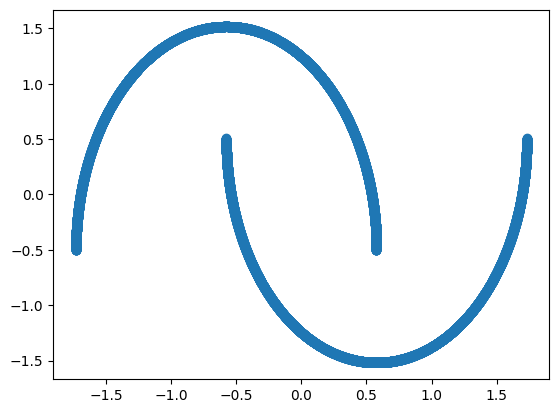

In [16]:
n_points = 10_000
DATASET = "moons"
data = get_data(DATASET, n_points)

%matplotlib inline
plt.scatter(data[:, 0], data[:, 1])
plt.show()

batch_size = 128
dataset = torch.from_numpy(data).float()
dataset = dataset.to(device)
dataset = torch.utils.data.TensorDataset(dataset) 
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)

In [17]:
from flow_matching.models import COTFM
from flow_matching.samplers import Sampler2D

In [18]:
n_epochs=5000

model=MLP(h=512).to(device) 
#model.apply(init_weights)
fm_type = DiffusionFM() 
optimizer=torch.optim.AdamW(model.parameters())
loss_fn=nn.MSELoss()


for i in tqdm(range(n_epochs)):
    for batch in dataloader:
        optimizer.zero_grad()
        
        x_1 = batch[0]  
        x_0 = torch.randn_like(x_1,dtype=torch.float32, device=device)    
        t = torch.rand(len(x_1), 1, dtype=torch.float32, device=device) * (1 - 1e-5)
        
        dx_t = fm_type.compute_dx_t(x_0, x_1, t)
        x_t = fm_type.compute_x_t(x_0, x_1, t) 
        
        v_pred = model(x_t, t)    
        loss = loss_fn(v_pred ,dx_t)
        
        loss.backward()
        
        optimizer.step()

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch 0, Loss: 3953.6631
Epoch 0, Loss: 2399.8916
Epoch 0, Loss: 165.9310
Epoch 0, Loss: 159.6455
Epoch 0, Loss: 25715.9102
Epoch 0, Loss: 184.5116
Epoch 0, Loss: 226.5820
Epoch 0, Loss: 370.3814
Epoch 0, Loss: 1256.8643
Epoch 0, Loss: 262.9249
Epoch 0, Loss: 339.5604
Epoch 0, Loss: 367.1455
Epoch 0, Loss: 131.5199
Epoch 0, Loss: 1450.7980
Epoch 0, Loss: 56.5208
Epoch 0, Loss: 166.3844
Epoch 0, Loss: 44.6969
Epoch 0, Loss: 2545.9426
Epoch 0, Loss: 354.6656
Epoch 0, Loss: 97.4763
Epoch 0, Loss: 1881.3384
Epoch 0, Loss: 90.3630
Epoch 0, Loss: 506.0331
Epoch 0, Loss: 51.5455
Epoch 0, Loss: 161.5276
Epoch 0, Loss: 293.5547
Epoch 0, Loss: 757.3763
Epoch 0, Loss: 2997.6523
Epoch 0, Loss: 7589.6450
Epoch 0, Loss: 233.5791
Epoch 0, Loss: 132.7508
Epoch 0, Loss: 285.5215
Epoch 0, Loss: 68.2465
Epoch 0, Loss: 22.3917
Epoch 0, Loss: 102447.9062
Epoch 0, Loss: 125.7736
Epoch 0, Loss: 1884.0105
Epoch 0, Loss: 75.2361
Epoch 0, Loss: 484.6364
Epoch 0, Loss: 96.0348
Epoch 0, Loss: 3490.4160
Epoch 0, L

  0%|          | 1/5000 [00:01<1:30:30,  1.09s/it]

Epoch 0, Loss: 230.6120
Epoch 0, Loss: 129.7360
Epoch 0, Loss: 220.2950
Epoch 0, Loss: 148.3685
Epoch 0, Loss: 201.2083
Epoch 0, Loss: 4290.7510
Epoch 0, Loss: 1520.2361
Epoch 0, Loss: 176.4823
Epoch 0, Loss: 236.5077
Epoch 0, Loss: 5329.3857
Epoch 0, Loss: 238.9158
Epoch 0, Loss: 133.2654
Epoch 0, Loss: 5377.6328


  0%|          | 14/5000 [00:19<1:56:06,  1.40s/it]


KeyboardInterrupt: 

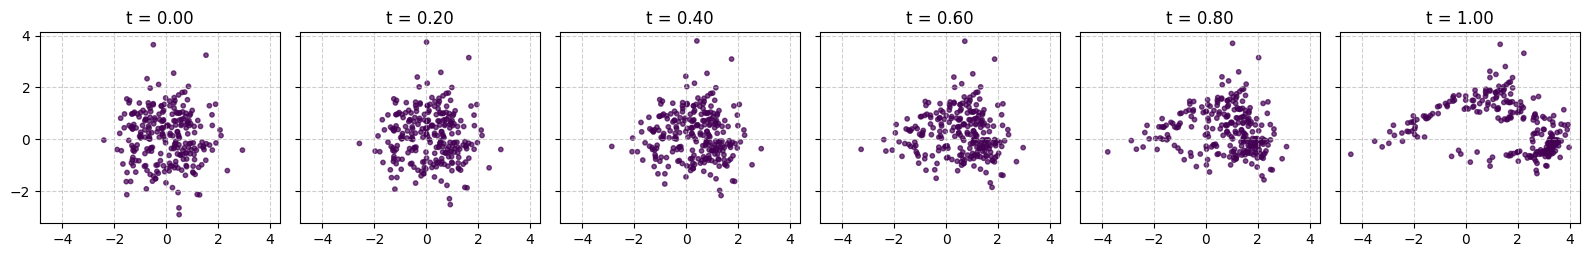

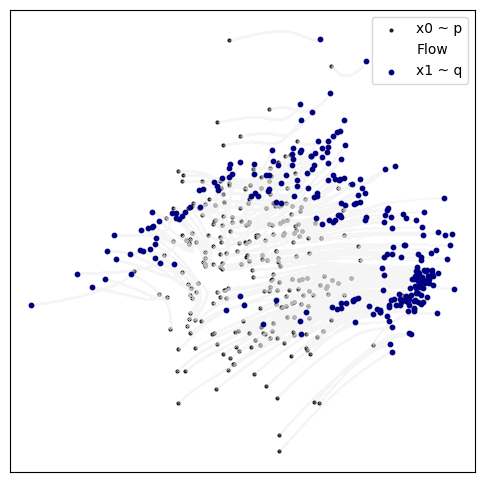

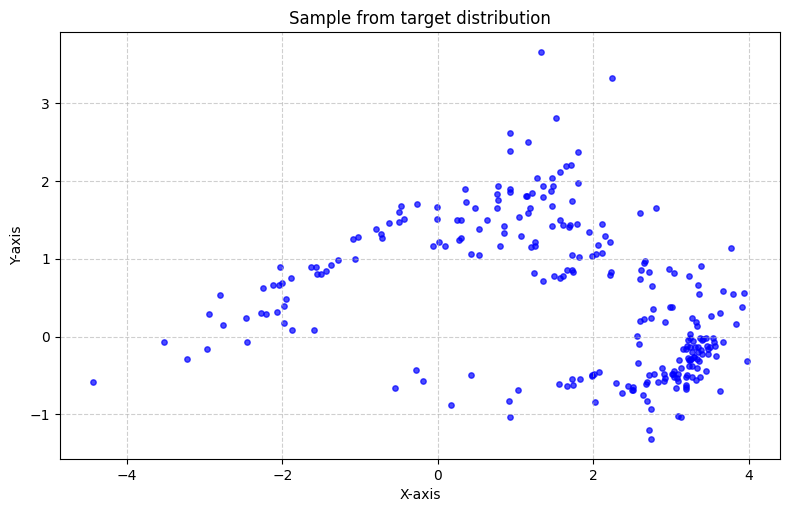

In [8]:
x_0 = torch.randn_like(x_1, dtype=torch.float32, device=device)
sampler = Sampler2D(model, x_0, time_steps=6, fm_method="diffusion", ode_method="dopri5", device=device)
sampler.plot_flow()
sampler.plot_trajectories()
sampler.plot_sample()

In [ ]:
n_epochs=20000
lr = 1e-3

model=SimpleNN().to(device)
fm_type = COTFM() 
optimizer=torch.optim.AdamW(model.parameters())
loss_fn=nn.MSELoss()


for i in tqdm(range(n_epochs)):
    
    optimizer.zero_grad()
    
    x_1 = torch.tensor(make_moons(256)[0], dtype=torch.float32, device=device)
    
    x_0 = torch.randn_like(x_1,dtype=torch.float32, device=device)
    
    t = torch.rand(len(x_1), 1, dtype=torch.float32, device=device)
    
    dx_t = fm_type.compute_dx_t(x_0, x_1, 0.)
    x_t = fm_type.compute_x_t(x_0, x_1,0., t) 
    
    v_pred = model(x_t, t)
    
    loss = loss_fn(v_pred ,dx_t)
    
    loss.backward()
    
    optimizer.step()
    
    if i % 1000 == 0:
        print(f"Epoch {i}, Loss: {loss.item():.4f}")

In [ ]:
x_0 = torch.randn_like(x_1, dtype=torch.float32, device=device)
sampler = Sampler2D(model, x_0, time_steps=6, method="dopri5", device=device)
sampler.plot_flow()
sampler.plot_trajectories()
sampler.plot_sample()